In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Importation des données

In [2]:
data = pd.read_csv('data01.csv')
X = data.drop('TARGET', axis = 1)
y = data['TARGET']
 

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

## 1- DummyRegressor

In [4]:
from sklearn.dummy import DummyRegressor
 
# Le fractionnement des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = DummyRegressor()
param_grid = {'strategy' : ['mean', 'median']}

kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

# les étapes du pipeline :
pipe = Pipeline([("equilib  ", SMOTE()), ('std', StandardScaler()),  ("dum", DummyRegressor())], verbose = True)
pipe.fit(X_train, y_train)
CV_gr = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold)
result = CV_gr.fit(X_train, y_train)

[Pipeline] ......... (step 1 of 3) Processing equilib  , total=   0.2s
[Pipeline] ............... (step 2 of 3) Processing std, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing dum, total=   0.0s


In [5]:
result.best_score_

-9.767028460820153e-07

In [6]:
bestParam = result.best_params_
bestParam

{'strategy': 'mean'}

## 2- KNeighborsClassifier

In [8]:
from sklearn.neighbors import KNeighborsClassifier

data = pd.read_csv('data01.csv')
X = data.drop('TARGET', axis = 1)
y = data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

model = KNeighborsClassifier()
param_grid = {'n_neighbors': [10,18,19,20],
             'weights': ['uniform', 'distance']} 

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

# les étapes du pipeline :
pipe = Pipeline([("equilib  ", SMOTE()), ('std', StandardScaler()),  ("knb", KNeighborsClassifier())], verbose = True)
pipe.fit(X_train, y_train)
CV_gr = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold, scoring='roc_auc', return_train_score=False)
result = CV_gr.fit(X_train, y_train)

[Pipeline] ......... (step 1 of 3) Processing equilib  , total=   0.2s
[Pipeline] ............... (step 2 of 3) Processing std, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing knb, total=   0.0s


In [9]:
result.best_score_

0.9216027874564461

In [16]:
bestParam = result.best_params_
bestParam

{'n_neighbors': 18, 'weights': 'distance'}

## 3- XGBoots Classifier

In [34]:
from xgboost import XGBClassifier
import xgboost

data = pd.read_csv('data01.csv')
X = data.drop('TARGET', axis = 1)
y = data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
scoring='roc_auc'
model = XGBClassifier()
param_grid = {'nthread':[2], # lors de l'utilisation de l'hyperthread, xgboost peut devenir plus lent
              'objective':['binary:logistic'],
              'n_estimators': [600,800],
              'learning_rate': [0.01, 0.02],
              'gamma': [2, 5],             
              'max_depth': [ 4] }

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

# les étapes du pipeline :
pipe = Pipeline([("equilib  ", SMOTE()), ('std', StandardScaler()),  ("xgb", XGBClassifier())], verbose = True)
pipe.fit(X_train, y_train)
CV_gr = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold, verbose=1)
result = CV_gr.fit(X_train, y_train)


[Pipeline] ......... (step 1 of 3) Processing equilib  , total=   0.4s
[Pipeline] ............... (step 2 of 3) Processing std, total=   0.2s
[Pipeline] ............... (step 3 of 3) Processing xgb, total=  14.6s
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [35]:
result.best_score_

0.9164924506387921

In [36]:
bestParam = result.best_params_
bestParam

{'gamma': 2,
 'learning_rate': 0.01,
 'max_depth': 4,
 'n_estimators': 600,
 'nthread': 2,
 'objective': 'binary:logistic'}

 ## 4- Forêt aléatoire

In [16]:
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('data01.csv')
X = data.drop('TARGET', axis = 1)
y = data['TARGET']

# Le fractionnement des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


model = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators' :[200, 500], 
                   'max_features': ['auto', 'sqrt', 'log2'],
                    'max_depth' : [4,5,6,7,8],
                    'criterion' :['gini', 'entropy'] }

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

# les étapes du pipeline :
pipe = Pipeline([("equilib  ", SMOTE()), ('std', StandardScaler()),  ("clas", RandomForestClassifier())], verbose = True)
pipe.fit(X_train, y_train)
CV_gr = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold, verbose=1)
result = CV_gr.fit(X_train, y_train)

[Pipeline] ......... (step 1 of 3) Processing equilib  , total=   0.2s
[Pipeline] ............... (step 2 of 3) Processing std, total=   0.1s
[Pipeline] .............. (step 3 of 3) Processing clas, total=   5.2s
Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [17]:
result.best_score_

0.9182346109175377

In [18]:
bestParam = result.best_params_
bestParam

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 200}

## Le meilleur modèle choisi est XGBoost Classifier

In [7]:
X = data.drop('TARGET', axis = 1)
y = data['TARGET']
#train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [10]:
from xgboost import XGBClassifier
import xgboost
model = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', nthread=1)


In [11]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=None, nthread=1, num_parallel_tree=None,
              predictor=None, ...)

In [12]:
y_pred = model.predict(X_test)

In [13]:
model.score(X_train, y_train)

0.9394037940379404

In [14]:
model.score(X_test, y_pred)

1.0

In [15]:
print(model.predict_proba(X_train))


[[0.94865537 0.05134465]
 [0.93647516 0.06352486]
 [0.9822308  0.01776919]
 ...
 [0.99326265 0.00673736]
 [0.932479   0.06752098]
 [0.9578828  0.04211719]]


In [16]:
print(model.predict_proba(X_test))

[[0.9765547  0.02344531]
 [0.63020754 0.36979243]
 [0.86460143 0.13539855]
 ...
 [0.9470915  0.05290849]
 [0.9688505  0.03114949]
 [0.9830432  0.01695679]]


In [17]:
print(classification_report(y_test,y_pred));

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2832
           1       0.44      0.03      0.05       243

    accuracy                           0.92      3075
   macro avg       0.68      0.51      0.51      3075
weighted avg       0.88      0.92      0.89      3075



In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[2823,    9],
       [ 236,    7]], dtype=int64)

In [19]:
import shap
explainer = shap.Explainer(model, X)
shap_values = explainer(X_test)

 99%|===================| 3034/3075 [01:24<00:01]        

### Les features les plus importants en moyenne EXT_SOURCE_3, EXT_SOURCE_2 et EXT_SOURCE_1

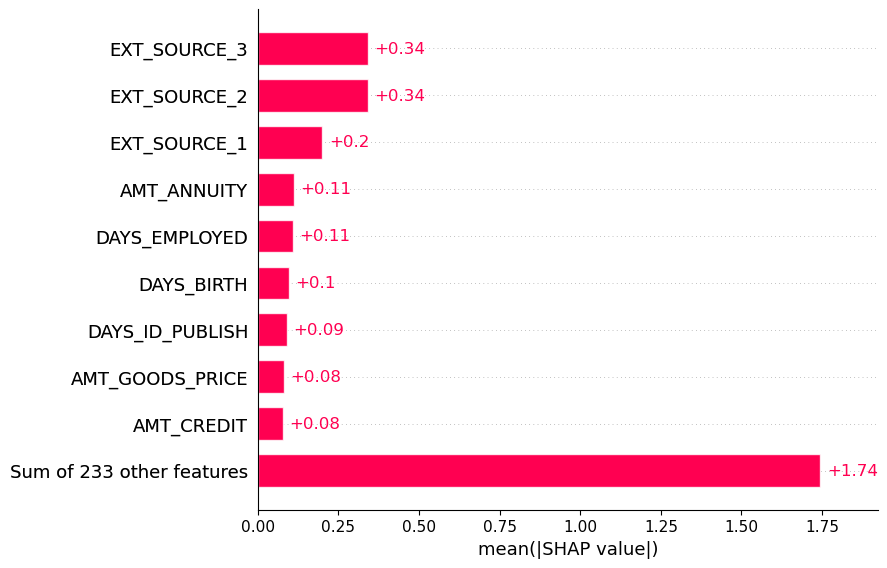

In [20]:
shap.plots.bar(shap_values)

### La courbe ROC Curve

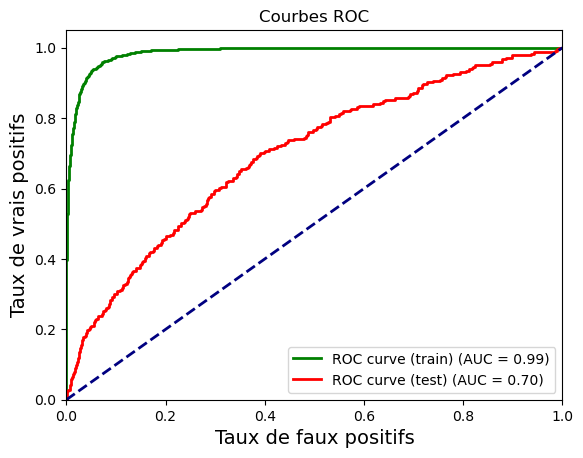

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
y_train_pred = model.predict_proba(X_train)[:, 1]
y_pred_proba = model.predict_proba(X_test)[:, 1]

[fpr_in, tpr_in, thr] = metrics.roc_curve(y_train, y_train_pred)
roc_auc_tr = auc(fpr_in, tpr_in)
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
roc_auc_test = auc(fpr, tpr)

plt.plot(fpr_in, tpr_in, color='green', lw=2, label='ROC curve (train) (AUC = %0.2f)' % roc_auc_tr)
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve (test) (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs', fontsize=14)
plt.ylabel('Taux de vrais positifs', fontsize=14)
plt.title('Courbes ROC')
plt.legend(loc="lower right")
plt.show()